# Curso Análisis de Redes

## Cátedra Teoría de las Telecomunicaciones - Universidad ORT Uruguay



# Modelado de la capa MAC de WiFi

In [1]:
#using Pkg;Pkg.instantiate(); Pkg.update()

## El estandar IEEE 802.11

El [estándar IEEE 802.11](https://www.ieee802.org/11/) se creó para definir un tronco común de
desarrollo de redes de área local inalámbricas (WLAN).

Un poco de historia:

 * **1997:** Aparece el IEEE 802.11, hoy legacy.
 * **1999:** 802.11a, capa física de 54Mbps (5GHz).
 * **1999:** 802.11b, capa física de 11Mbps (2.4GHz).
 * **2000:** Se crea la WiFi Alliance.
 * **2003:** 802.11g, capa física de 54Mbps (2.4GHz).
 * **2005:** 802.11e, QoS Capabilities, service differentiation.
 * **2007:** 802.11-2007, norma que integra los ammendements ya aprobados.
 * **2010:** 802.11n, capa física de 300Mbps.
 * **2011:** 802.11s, soporte para mesh networks (draft).
 * **2016:** 802.11-2016, norma que integra los ammendements ya aprobados.
 * Más recientemente, 802.11ac, etc. etc. etc.

### Evolución 

 * Originalmente el estándar proponía el uso de capa física *infrarroja* (802.11 legacy).
 * Los bitrates previstos eran de 1 a 2 Mbps sobre distancias cortas (un salón).
 * Normas posteriores introdujeron la radio spread spectrum basada en DHSS/CCK (b) y DHSS/CCK/OFDM (g). Aquí fue que WiFi comenzó a volverse popular.
 * Debido a las diferentes velocidades, se debe agregar una *una subcapa de convergencia física* (Physical Layer Convergence Protocol, PLCP).
     * **Idea:** debo agregar un encabezado de capa física que indique *qué velocidad/modulación* se va a usar para los datos.
 * En sucesivos updates, la compatibilidad hacia atrás se volvió un peso por la diversidad de rates a soportar.


### Ejemplo: 802.11b

En 802.11b se definieron 4 velocidades de modulación:

 * 1 y 2Mbps basados en DBPSK y DQPSK.
 * 5.5 y 11Mbps basados en CCK (complementary code keying)
 
Estas velocidades de modulación solo afectan a la parte MAC. Se debe agregar el encabezado PLCP para:

 * Sincronizar al receptor (preámbulo).
 * Indicar el modo de transmisión de la parte de datos.

### El encabezado PLCP de 802.11b

![PLCP header](../images/plcp_long_preamble.png)

### Ejemplo

Consideremos un paquete que a nivel de MAC contiene $1500$ bytes incluyendo encabezados:

* Tiempo de transmisión a $1Mbps$:

$$T_{tr} = PLCP + \frac{8L}{1Mbps} = 192 + \frac{12000}{1.0} = 12192 \mu s$$
es decir, un $1.6\%$ extra.

* Tiempo de transmisión a $11Mbps$:

$$T_{tr} = PLCP + \frac{8L}{11Mbps} = 192 + \frac{12000}{11.0} = 1282 \mu s$$
es decir un $17.6\%$ extra.

Y esto sin contar los overhead de coordinación (MAC).

### El encabezado PLCP de 802.11b - short preamble

En el caso de 802.11b se comenzó a usar encabezados PLCP más cortos (short preamble) para mejorar esto:

![PLCP header](../images/plcp_short_preamble.png)

### Ejemplo: 802.11a/g

En estas propuesta, se buscó llevar la velocidad de modulación a $54$ Mbps utilizando OFDM. En el caso de 802.11a se hizo en la banda de 5Ghz y en 802.11g en la banda de 2.4Ghz (más popular debido a su penetración).

**Formato de trama**:

![80211ag preamble](../images/plcp_80211ag.png)

**Más detalles:** [Reporte sobre la capa física 802.11](https://www.cnrood.com/en/media/solutions/Wi-Fi_Overview_of_the_802.11_Physical_Layer.pdf)

## El mecanismo de acceso al medio (DCF)

El mecanismo de acceso se basa en el Binary Exponential Backoff de Ethernet, y que es análogo al CSMA que ya vimos. Permite opcionalmente utilizar el mecanismo RTS/CTS para reservar el acceso al medio.

> **Binary exponential backoff:**
> * Cada estación mantiene una ventana mínima de backoff $W=CW_{min}$ (slots).
> * Al intentar transmitir un paquete, se sortea uniforme un contador entre $0$ y $W-1$. Se espera esta cantidad de slots antes de transmitir (es decir se va decrementando el contador).
> * Al llegar a $0$ transmite. Si hay colisión (se detecta porque no se recibe ACK), la próxima vez se duplica $W$ y se sortea en un intervalo más largo (hasta un máximo $CW_{max}$ posible).
> * Si se transmite con éxito, se vuelve a $W=CW_{min}$.

A su vez la norma define algunos tiempos (varían de acuerdo al estándar):

* *DIFS*: tiempo para declarar el medio libre.
* *SIFS*: tiempo de espera del ACK.
* *SlotTime*: tiempo de slot de backoff.

## Mecanismo DCF: diagrama temporal


![802.11 DCF](../images/80211_dcf.png)

### Ejemplo: 802.11b con una sola estación.

Calculemos el tiempo total de transmisión en 802.11b cuando una sola estación accede. Notar que dicha estación *debe igualmente hacer* backoff al final de cada transmisión (para permitir entrar a otras).

Como está sola, aproximaremos su tiempo de backoff por $CW_{min}/2$ slots.

$$T_{total} = DIFS + \frac{CW_{min}}{2}T_{slot} + PLCP + \frac{8L}{PHY} + SIFS + PLCP + \frac{8L_{ack}}{PHY}$$

Siendo:

* $DIFS = 50\mu s$
* $CW_{min} = 32$
* $T_{slot} = 20\mu s$
* $PLCP = 192 \mu s$
* $L = 1500$ bytes.
* $SIFS = 10\mu s$.
* $L_{ack} = 14$ bytes.
* $PHY \in \{1, 2, 5.5, 11\}$ Mbps.


In [2]:
function tiempo_80211b(PHY, L)
    #devuelve el tiempo de transmision en us si PHY esta en Mbps y L en bytes
    DIFS = 50
    CW = 32
    Tslot = 20
    PLCP = 192
    Ttr = 8*L/PHY
    SIFS = 10
    Tack = 8*14/PHY
    
    Ttotal = DIFS + CW/2*Tslot + PLCP + Ttr + SIFS + PLCP + Tack
    return Ttotal
end

tiempo_80211b (generic function with 1 method)

In [3]:
t1 = tiempo_80211b(1.0,1500)
t2 = tiempo_80211b(2.0,1500)
t5_5 = tiempo_80211b(5.5,1500)
t11 = tiempo_80211b(11.0,1500)

Thr1 = 8*1500/t1
Thr2 = 8*1500/t2
Thr5_5 = 8*1500/t5_5
Thr11 = 8*1500/t11

println("Throughputs de 802.11b, estacion simple:")
println("PHY=1Mbps: $Thr1")
println("PHY=2Mbps: $Thr2")
println("PHY=5.5Mbps: $Thr5_5")
println("PHY=11Mbps: $Thr11")

Throughputs de 802.11b, estacion simple:
PHY=1Mbps: 0.9319664492078286
PHY=2Mbps: 1.7595307917888563
PHY=5.5Mbps: 4.045605001838911
PHY=11Mbps: 6.434002729576915


### Ejemplo: 802.11g con una sola estación.

Con la misma idea, en 802.11g se calcula igual, salvo que cambian los tiempos de la norma:

$$T_{total} = DIFS + \frac{CW_{min}}{2}T_{slot} + PLCP + \frac{8L}{PHY} + SIFS + PLCP + \frac{8L_{ack}}{PHY}$$

Siendo:

* $DIFS = 34\mu s$
* $CW_{min} = 16$
* $T_{slot} = 9\mu s$
* $PLCP = 20 \mu s$
* $L = 1500$ bytes.
* $SIFS = 16\mu s$.
* $L_{ack} = 14$ bytes.
* $PHY \in \{6, 9, 12, 18, 24, 35, 48, 54\}$ Mbps.


In [4]:
function tiempo_80211g(PHY, L)
    #devuelve el tiempo de transmision en us si PHY esta en Mbps y L en bytes
    DIFS = 34
    CW = 16
    Tslot = 9
    PLCP = 20
    Ttr = 8*L/PHY
    SIFS = 16
    Tack = 8*14/PHY
    
    Ttotal = DIFS + CW/2*Tslot + PLCP + Ttr + SIFS + PLCP + Tack
    return Ttotal
end

tiempo_80211g (generic function with 1 method)

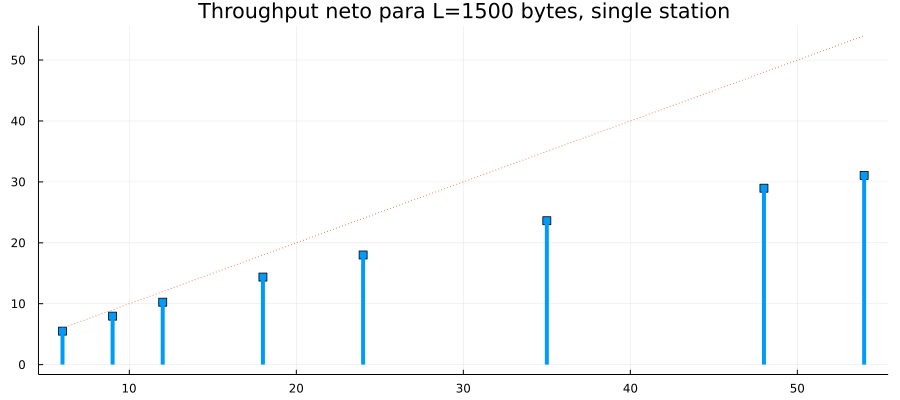

In [5]:
using Plots, LaTeXStrings
default(size=(900,400), legend=:bottomright, legendfontsize=10)

L=1500
PHY = [6,9,12,18,24,35,48,54]
Thr = [8*L/tiempo_80211g(phy,L) for phy in PHY]

plot(PHY, Thr, lt=:stem, lw=4, marker=:square, title="Throughput neto para L=1500 bytes, single station", legend=:none)
plot!(PHY,PHY,ls=:dot)

## Modelo de una celda 802.11 en saturación.

Deseamos realizar un modelo de una celda 802.11 donde $N$ estaciones compiten por el acceso al medio. Supondremos que estamos en condiciones de saturación (siempre hay paquetes) y que todas las estaciones se ven entre sí.

Para poder realizar un análisis del caso de múltiples estaciones, del estilo del análisis por ciclos, necesitamos modelar adecuadamente el *proceso de backoff* para calcular la *probabilidad neta de acceso al medio*.

**Modelo (G. Bianchi, 2000):**

 * Se realiza un modelo de Markov del proceso de backoff, en función de los parámetros de la norma. Identifica la probabilidad condicional de colisión (cuantas colisiones ve cada estación) y la probabilidad neta de acceso al medio del Binary Exponential Backoff.
 
 * Utilizando la probabilidad resultante y un análisis por ciclos, determina el throughput resultante en una celda de $N$ estaciones accediendo mediante DCF en saturación.
 


### Modelo del proceso de backoff: caso simple.

Para entender el modelo, conviene comenzar con el caso en que la ventana de Backoff $W$ es fija (no se duplica). Sea $b(t)$ el valor actual del contador. 

El proceso $b(t)$ es una CMTD con el siguiente diagrama:

![Cadena backoff simple](../images/simple_backoff.png)

### Probabilidad de acceso: ec. de balance

Planteando ecuaciones de balance se obtiene:

$$\begin{align}
\pi_0& \frac{W-1}{W} = \pi_1 \\
\pi_1 &= \pi_0 \frac{1}{W} + \pi_2 \\
\pi_2 &= \pi_0 \frac{1}{W} + \pi_3 \\
&\ldots \\
\pi_{W-2} &= \pi_0 \frac{1}{W} + \pi_{W-1}\\
\pi_{W-1} &= \pi_0 \frac{1}{W}
\end{align}$$

Despejando se obtiene:
$$\pi_k = \frac{W-k}{W} \pi_0, \quad k=0,\ldots,W-1$$

### Probabilidad de acceso

Planteando:

$$1 = \sum_{k=0}^{W-1} \pi_k = \pi_0 \frac{1}{W} \sum_{k=0}^{W-1} (W-k) = \pi_0 \frac{1}{W} \frac{W(W+1)}{2}= \pi_0\frac{W+1}{2}$$

De donde la probabilidad en régimen de que el contador de backoff esté en $0$ (probabilidad de acceso) es:

$$p = P(acceso) = \pi_0 = \frac{2}{W+1}$$

Asumiendo que los procesos de backoff de cada estación se comportan de manera independiente, podemos hacer un análisis por ciclos utilizando esta $p$.

### Modelo del proceso de backoff: caso completo.

En la práctica, el backoff va entre $0$ y $W-1$, pero si se colisiona se duplica la ventana. Si se transmite exitosamente, se vuelve a la ventana básica. Sea $p_c$ la *probabilidad condicional de colisión*, es decir, la probabilidad de que haya una colisión dado que una estación transmite.

Sea $s(t),b(t)$ el proceso que cuenta el estado de la ventana y el contador actual. Es una CMTD con el siguiente diagrama:

![Backoff model](../images/complete_backoff.png)

### Probabilidad de acceso

Afortunadamente, la cadena anterior se resuelve para el caso en que $W_i = 2^iW_0$. Básicamente en cada renglón se comporta como la que ya vimos. La probabilidad de acceso es:

$$p = \sum_{s=0}^m \pi_{s,0} = \frac{2(1-2p_c)}{(1-2p_c)(W+1) +p_c W(1-(2p_c)^m)}$$

**Observación:** si $m=0$, es decir, nunca se duplica, $p=2/(W+1)$ como hallamos antes.

El resultado nos dice cuál es la tasa de acceso neta del proceso de backoff para una probabilidad de colisión dada.

### Probabilidad condicional de colisión

La ecuación anterior nos da una relación para la probabilidad de acceso. ¿Cuál será la probabilidad condicional de colisión?

Supongamos nuevamente que estamos en saturación y hay $N$ estaciones tratando de transmitir.

**Idea:** si cada estación está haciendo backoff de manera independiente, cada una tiene una probabilidad neta de acceso $p$.

Dado que una transmite, la probabilidad condicional de colisión será la probabilidad de que **alguna más lo haga**:

$$p_c = 1 - (1-p)^{N-1}.$$


### Modelo completo de una celda WiFi con colisiones.

Para hallar la probabilidad neta de acceso y de colisión resultantes, debemos resolver entonces el sistema de ecuaciones:

$$\begin{align}
p &= \frac{2(1-2p_c)}{(1-2p_c)(W+1) +p_c W(1-(2p_c)^m)},\\
p_c &= 1- (1-p)^{N-1}.
\end{align}$$

El resultado $p^*, p_c^*$ nos dará la probabilidad de acceso y la probabilidad condicional de colisión en que operará el sistema.

Luego usamos $p^*$ para realizar un análisis por ciclos.

### Ejemplo

Supongamos que $CW_{min}=W=32$, $m=5$ (corresponde a $CW_{max}=1024$) y $N=20$ estaciones: 

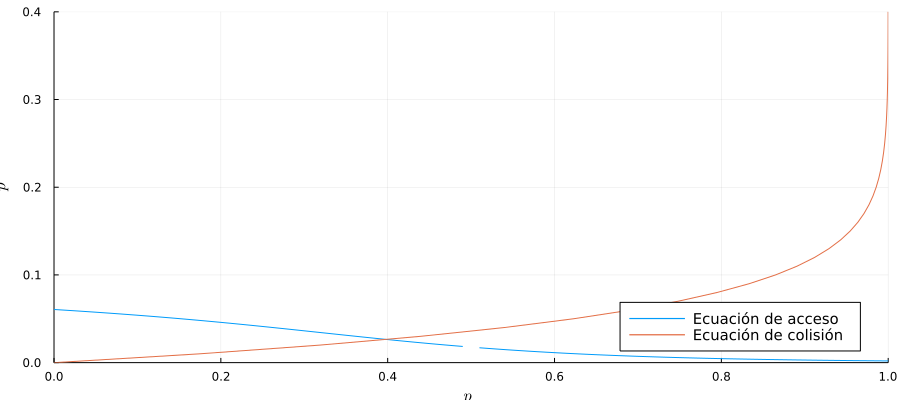

In [6]:
p_acceso(pc,W,m) = 2*(1-2*pc)/((1-2*pc)*(W+1) + pc*W*(1-(2*pc)^m))
p_col(p,N) = 1-(1-p)^(N-1)

W=32
m=5
N=20
p=(0:0.01:1)
pc=(0:0.01:1)
plot(pc,p_acceso.(pc,W,m),label="Ecuación de acceso", xlabel=L"p_c", ylabel=L"p", xlims=(0,1),ylims=(0,0.4))
plot!(p_col.(p,N),p, label="Ecuación de colisión")

### Observaciones

* El modelo aplica al proceso de Backoff de $N$ estaciones colisionando, independientemente de si luego se utiliza RTS/CTS o no como mecanismo de reserva.
* Análogamente, es independiente de la velocidad de transmisión física de los clientes.

Las observaciones anteriores permiten **desacoplar** el análisis de la probabilidad de acceso $p^*$ (y su consiguiente $p_c^*$) del estudio de la performance de la celda usando tiempos.

 * Simplemente hay que hacer un análisis por ciclos utilizando los tiempos de transmisión y colisión adecuados para la norma empleada.
 
 * Tomando como entrada el no. de estaciones y su probabilidad neta de acceso $p^*$.
 
El método anterior resulta entonces muy poderoso para modelar cualquier celda WiFi, como veremos en el ejercicio al final del cuaderno y en el obligatorio.

## El problema de las múltiples velocidades

Hasta ahora hemos analizado el acceso al medio en condiciones mayormente homogéneas. ¿Qué ocurre cuando diferentes estaciones tienen diferentes velocidades de acceso, como permite la norma WiFi?

### Ejemplo

Hagamos un ejemplo con el CSMA básico. Consideremos dos estaciones accediendo con probabilidad $p$, utilizando CSMA básico y con largo de paquete $L_{tr}$ en bits. Sea $\sigma$ la duración del slot.

Supongamos que la estación $1$ puede transmitir el paquete (descontando encabezados) a velocidad $C_1$ (bits por segundo) y la estación $2$ lo hace a velocidad $C_2 < C_1$.

### Analisis por ciclos

Realicemos un análisis por ciclos, teniendo en cuenta qué estación transmite:

**Casos:**

 * Slot Idle: si nadie transmite. Probabilidad $(1-p)^2$.
 * Éxito 1: si transmite solo 1. Probabilidad $p(1-p)$.
 * Éxito 2: si transmite solo 2. Probabilidad $p(1-p)$.
 * Colisión: en otro caso. Probabilidad $p^2$.
 
**Tabla de ciclos**:

| Caso  | Prob.  | $L$ | $T$  |
|---|:-----------:|---|:---:|
| Idle | $$(1-p)^2$$  | $0$  | $\sigma$  |
| Exito  1| $p(1-p)$  | $L_{tr}$ | $L_{tr}/C_1$ |
| Exito  2| $p(1-p)$  | $L_{tr}$ | $L_{tr}/C_2$ |
| Colision | $p^2$  | $0$  | $L_{tr}/\min\{C_1,C_2\} = L_{tr}/C_2$  |


### Calculo del throughput

Se tiene que:

$$\bar{L} = 2p(1-p) L_{tr}$$

$$\bar{T} = \sigma (1-p)^2  + p(1-p)\left(\frac{L_{tr}}{C_1} + \frac{L_{tr}}{C_2}\right) + p^2 \frac{L_{tr}}{C_2}.$$ 

Y por lo tanto:

$$Thr = \frac{\bar{L}}{\bar{T}} = \frac{2p(1-p) L_{tr}}{\sigma (1-p)^2  + p(1-p)\left(\frac{L_{tr}}{C_1} + \frac{L_{tr}}{C_2}\right) + p^2 \frac{L_{tr}}{C_2}}.$$

o bien:

$$Thr = \frac{2}{ \left(\frac{1}{C_1} + \frac{1}{C_2}\right) + \frac{\sigma (1-p)}{pL_{tr}} + \frac{p}{(1-p)} \frac{1}{C_2}}.$$

### Cota del throughput

En el escenario anterior, es fácil ver que el throughput debe verificar:

$$Thr \leqslant \frac{2}{\frac{1}{C_1} + \frac{1}{C_2}}$$

es decir, el throghput de la celda es la *media armónica* de las velocidades de modulación. En particular, como $C_2<C_1$

$$Thr \leqslant 2C_2.$$

Es decir, ¡la velocidad lenta domina el throughput de la celda!

**Ejemplo:** supongamos que $C_1=11Mbps$ y $C_2=1Mbps$, entonces necesariamente:

$$Thr \leqslant \frac{2}{1/11+1/1} = 1.83 Mbps.$$

Como cada estación tiene la misma probabilidad de acceso, se repartirán por igual dicho throughput. El de $C_1=11Mbps$ se ve claramente perjudicado.

### Throughput con diferentes velocidades

Tomemos $C_1=11Mbps$, $C_2=1Mbps$, $L_{tr}=1500$ bytes y un tiempo de slot $\sigma=20\mu s$ en el ejemplo anterior, y grafiquemos el throughput en función de $p$:

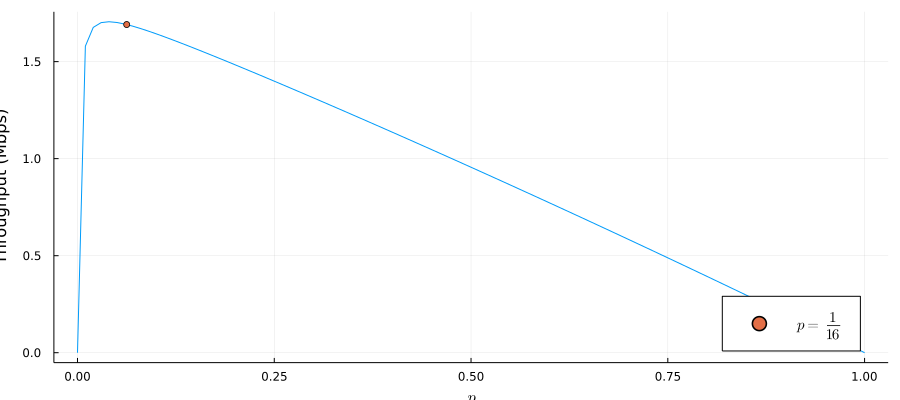

In [7]:
C1=11.0
C2=1.0
L=1500*8
sigma = 20.0

throughput(p) = 2*p*(1-p)*L/( (1-p)^2*sigma + p*(1-p)L/C1 + p*(1-p)*L/C2 + p^2*L/min(C1,C2))

p=(0:0.01:1)

plot(p,throughput.(p), label=:none, xlabel=L"p", ylabel="Throughput (Mbps)")
scatter!([1/16],[throughput.(1/16)], label=L"p=\frac{1}{16}")

### Probabilidad óptima de acceso:

Para completar el ejemplo, veamos que para maximizar el throughput hay que minimizar:

$$g(p) = \frac{\sigma (1-p)}{pL_{tr}} + \frac{p}{(1-p)} \frac{1}{C_2}$$

Calculando queda:

$$ 0 = g'(p) = \frac{\sigma}{L_{tr}} \frac{-1}{p^2} + \frac{1}{C_2} \frac{1}{(1-p)^2}$$

Llamando $\beta= \frac{\sigma C_2}{L_{tr}}$ (relación entre tiempo slot y tiempo de transmisión lenta), la condición del óptimo es:

$$\frac{p^*}{1-p^*} = \sqrt{\beta}.$$

O bien $p^* = \frac{\sqrt{\beta}}{1+\sqrt{\beta}}$.

Retomando los valores del ejemplo anterior:

In [8]:
beta = sigma*C2/L
p_opt = sqrt(beta)/(1+sqrt(beta))
Thr = throughput(p_opt)

println("beta = $beta, prob. optima= $p_opt, Throughput optimo = $Thr")

beta = 0.0016666666666666668, prob. optima= 0.03922353493794955, Throughput optimo = 1.7056714656749548


### Múltiples velocidades: conclusión

Este problema es independiente de las colisiones (la cota anterior funciona aún en el caso ideal). Incluso es un problema en downlink (solo el AP transmitiendo) si la cantidad de paquetes para cada estación es más o menos la misma.

**Conclusión:** La combinación de múltiples velocidades con igual chance de acceso **empeora el throughput**. En general:

$$Thr \leqslant \frac{1}{\frac{1}{n}\sum_{k=1}^n \frac{1}{C_k}} \leqslant n \min C_k,$$

es decir, todas se llevan menos que la más lenta.

### Múltiples velocidades: soluciones

**Ideas:**

 * Dar diferentes probabilidades de acceso en función de la velocidad de modulación (por ejemplo tocando las ventanas de backoff).
 
 * Mantener colas diferenciadas en el AP para darle más prioridad a las velocidades altas.
 
 * Asignar tamaños distintos de paquete transmitido a cada estación, por ejemplo agregando paquetes para un mismo destino (es el camino de 802.11n).
 
**Objetivo:** Conseguir "air-time fariness", es decir, que todas las estaciones tengan un mismo *tiempo* de acceso en lugar de las mismas *oportunidades de acceso*. De este modo, las estaciones más rápidas lo aprovechan de manera más eficiente.

## Ejercicio

Considere la norma IEEE 802.11b básica de 1Mbps. Suponga que hay $N=5$ estaciones y se utilizan paquetes de largo $L=1500$ bytes. La ventana básica es $CW_{min}=32$ y la ventana máxima $CW_{max}=1024$, correspondiente a $5$ duplicaciones. Los restantes tiempos de transmisión y slot son como antes.

1. Resuelva el sistema de ecuaciones del modelo de Bianchi para esta celda y calcule la probabilidad neta de acceso.

2. Realice el análisis por ciclos resultante y calcule el Throughput neto de la celda suponiendo que se usa RTS/CTS y que no. Compare los resultados y compare con el ejercicio del cuaderno anterior.

Algunos datos de la norma:

* Tiempo de espera a medio libre (DIFS): $50\mu s$.
* Tiempo de transmisión de un paquete: $T_{datos} + T_{PHY} + T_{MAC} + T_{ack}$ siendo:
    * $T_{PHY} = 192 \mu s$
    * $T_{MAC} = 160 $bits (transmitidos a la misma velocidad que los datos).
    * $T_{ack} = T_{PHY} + 10 \mu s + 14 bytes$ (transmitidos a la misma velocidad que los datos).
    
* Para el caso de RTS/CTS:
    * $T_{RTS} = T_{PHY} + 10 \mu s + 20 bytes = 362 \mu s$ (los bytes van transmitidos a 1Mbps).
    * $T_{CTS} = T_{PHY} + 10 \mu s + 14 bytes = 314 \mu s$ (los bytes van transmitidos a 1Mbps).